In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import List

In [2]:
from dataset import Dataset, Graph
from models import NodeConvGNN, EdgeConvGNN
from experiment import evaluate_breakdown, Configs, evaluate

In [3]:
conf = Configs()
# conf.input_dim = 130

def draw_roc_curve(model, set):
    outputs = torch.zeros(len(set), dtype=torch.float, device=conf.device)
    targets = torch.zeros(len(set), dtype=torch.float, device=conf.device)
    for i, graph in enumerate(set):
        output = model(graph.node_feat, graph.edge_index, graph.line_edge_index, graph.index01)
        outputs[i] = output
        targets[i] = graph.targets.to(torch.float)

    tprs = []
    fprs = []
    n_samples = 50
    for threshold in torch.linspace(0, 1, n_samples):
        eval = evaluate_breakdown(outputs, targets, threshold=threshold)
        tprs.append(eval["tpr"])
        fprs.append(eval["fpr"])
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.plot(fprs, tprs, label=model.__class__.__name__, marker='o')

In [6]:
mean = lambda x : sum(x) / len(x)

dataset = Dataset("data/PPIDataset")
print("Average train graph size:", mean([len(graph.node_feat) for graph in dataset.train_graphs]), mean([graph.edge_index.shape[1] for graph in dataset.train_graphs]))
print("Average train line graph size:", mean([len(graph.node_feat) for graph in dataset.train_graphs]), mean([graph.line_edge_index.shape[1] for graph in dataset.train_graphs]))

Average train graph size: 92.14148148148148 1572.2374074074073
Average train line graph size: 92.14148148148148 59900.554814814815


In [4]:
# Visualize the ROC curve of the models

node_conv_model = NodeConvGNN(input_dim=conf.input_dim, hidden_dim=52)
node_conv_model.load_state_dict(torch.load('../study/PPI-hidden-dim-52/PPI-node_conv-80.pth'))
node_conv_model.eval()
node_conv_model.to(conf.device)

dataset = Dataset("data/PPIDataset")
# Remove graphs with too large line graphs
dataset.train_graphs = [graph for graph in dataset.train_graphs if graph.line_edge_index.shape[1] < 250000]
dataset.test_graphs = [graph for graph in dataset.test_graphs if graph.line_edge_index.shape[1] < 250000]
print("After removing large line graphs")
print("Number of train graphs:", len(dataset.train_graphs))
print("Number of test graphs:", len(dataset.test_graphs))
dataset.to(conf.device)

edge_conv_model = EdgeConvGNN(input_dim=conf.input_dim, hidden_dim=52)
edge_conv_model.load_state_dict(torch.load('../study/PPI-hidden-dim-52/PPI-edge_conv-80.pth'))
edge_conv_model.eval()
edge_conv_model.to(conf.device)

After removing large line graphs
Number of train graphs: 5058
Number of test graphs: 528


EdgeConvGNN(
  (convs): ModuleList(
    (0): GCNConv(104, 52)
    (1): GCNConv(52, 52)
  )
  (linear): Linear(in_features=52, out_features=1, bias=True)
)

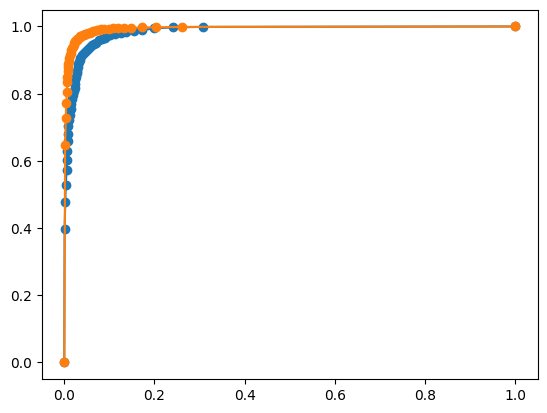

In [5]:
draw_roc_curve(node_conv_model, dataset.train_graphs)
draw_roc_curve(edge_conv_model, dataset.train_graphs)
plt.legend()
plt.show()

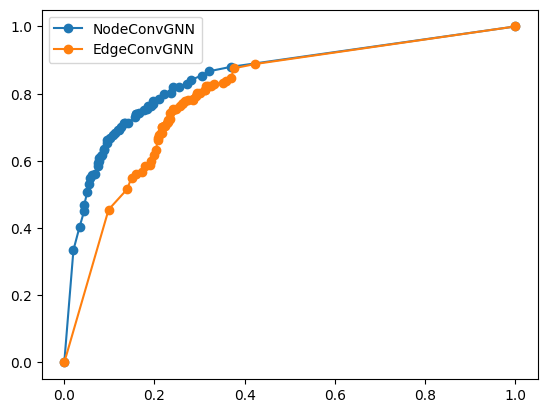

In [9]:
draw_roc_curve(node_conv_model, dataset.test_graphs)
draw_roc_curve(edge_conv_model, dataset.test_graphs)
plt.legend()
plt.show()

In [5]:
print(evaluate(node_conv_model, dataset.train_graphs, conf=conf, eval_auc=True))
print(evaluate(edge_conv_model, dataset.train_graphs, conf=conf, eval_auc=True))

{'loss': 0, 'acc': 0.9996045867931989, 'auc': tensor(0.9925)}
{'loss': 0, 'acc': 0.9958481613285883, 'auc': tensor(0.9844)}


In [6]:
print(evaluate(node_conv_model, dataset.test_graphs, conf=conf, eval_auc=True))
print(evaluate(edge_conv_model, dataset.test_graphs, conf=conf, eval_auc=True))

{'loss': 0, 'acc': 0.7537878787878788, 'auc': tensor(0.7743)}
{'loss': 0, 'acc': 0.75, 'auc': tensor(0.7749)}


In [11]:
print(node_conv_model.convs[0].lin.weight.shape)

total_params = 0
for name, param in node_conv_model.named_parameters():
    if param.requires_grad:
        num_params = param.numel()
        print(f"Submodule: {name}, Number of Parameters: {num_params}")
        total_params += num_params

print(f"Total Number of Learnable Parameters: {total_params}")


torch.Size([52, 52])
Submodule: convs.0.bias, Number of Parameters: 52
Submodule: convs.0.lin.weight, Number of Parameters: 2704
Submodule: convs.1.bias, Number of Parameters: 52
Submodule: convs.1.lin.weight, Number of Parameters: 2704
Submodule: linear.weight, Number of Parameters: 104
Submodule: linear.bias, Number of Parameters: 1
Total Number of Learnable Parameters: 5617


In [12]:
from models import NodeConvGNN

model = NodeConvGNN(input_dim=52, hidden_dim=20)
print(model.convs[0].lin.weight.shape)

torch.Size([20, 52])


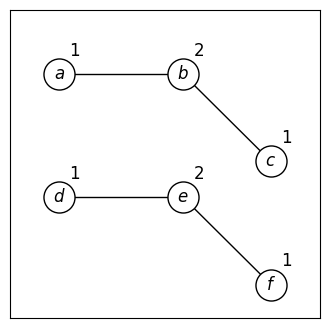

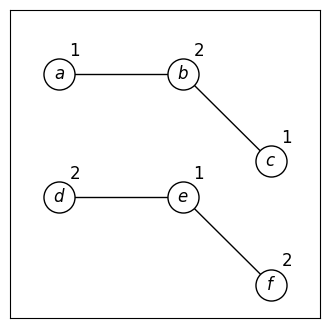

In [2]:
# Draw G1 and G2

def position_dict(node_ids, positions):
    return {node_ids[i]: positions[i] for i in range(len(node_ids))}

# Create graph
G = nx.Graph()
n1 = 'u'
n2 = 'v'
n3 = 'w'
n4 = 'x'
n5 = 'y'
n6 = 'z'
node_ids = [n1, n2, n3, n4, n5, n6]

G.add_nodes_from([
    (n1, dict(name="$a$", label1="$1$", label2="$1$")),
    (n2, dict(name="$b$", label1="$2$", label2="$2$")),
    (n3, dict(name="$c$", label1="$1$", label2="$1$")),
    (n4, dict(name="$d$", label1="$1$", label2="$2$")),
    (n5, dict(name="$e$", label1="$2$", label2="$1$")),
    (n6, dict(name="$f$", label1="$1$", label2="$2$")),
])
G.add_edge(n1, n2)
G.add_edge(n2, n3)
G.add_edge(n4, n5)
G.add_edge(n5, n6)

# Set node positions
theta = np.pi * 45 / 180
positions = np.array([
    [-1, 0],
    [0, 0],
    [np.cos(theta), -np.sin(theta)],
])
positions *= 0.8
positions -= (positions.max(axis=0) + positions.min(axis=0))/2  # center the positions
positions += np.array([0, 0.3]) # center the positions in the upper half of the plot
positions = np.vstack([positions, positions - np.array([0, 0.8])])
original_graph_positions = positions.copy()
node_pos = position_dict(node_ids, positions)


# Set label positions
label_positions = positions + np.array([0.1, 0.15])
label_pos = position_dict(node_ids, label_positions)

# Labels to display
node_names = {node: data['name'] for node, data in G.nodes(data=True)}
node_labels1 = {node: data['label1'] for node, data in G.nodes(data=True)}
node_labels2 = {node: data['label2'] for node, data in G.nodes(data=True)}

# Draw G1
plt.figure(frameon=False, figsize=(4, 4))
plt.xlim(-1,1)
plt.ylim(-1,1)
nx.draw_networkx_nodes(G, node_pos, node_size=500, node_color='white', edgecolors='black')
nx.draw_networkx_labels(G, labels=node_names, pos=node_pos)
nx.draw_networkx_labels(G, labels=node_labels1, pos=label_pos)
nx.draw_networkx_edges(G, node_pos, edgelist=G.edges())
plt.show()

# Draw G2
plt.figure(frameon=False, figsize=(4, 4))
plt.xlim(-1,1)
plt.ylim(-1,1)
nx.draw_networkx_nodes(G, node_pos, node_size=500, node_color='white', edgecolors='black')
nx.draw_networkx_labels(G, labels=node_names, pos=node_pos)
nx.draw_networkx_labels(G, labels=node_labels2, pos=label_pos)
nx.draw_networkx_edges(G, node_pos, edgelist=G.edges())
plt.show()

<>:13: SyntaxWarning: invalid escape sequence '\{'
<>:14: SyntaxWarning: invalid escape sequence '\{'
<>:15: SyntaxWarning: invalid escape sequence '\{'
<>:16: SyntaxWarning: invalid escape sequence '\{'
<>:13: SyntaxWarning: invalid escape sequence '\{'
<>:14: SyntaxWarning: invalid escape sequence '\{'
<>:15: SyntaxWarning: invalid escape sequence '\{'
<>:16: SyntaxWarning: invalid escape sequence '\{'
C:\Users\jonas\AppData\Local\Temp\ipykernel_40496\2814511013.py:13: SyntaxWarning: invalid escape sequence '\{'
  (n1, dict(name="$ab$", label1="$\\xi (\{ 1,2 \})$")),
C:\Users\jonas\AppData\Local\Temp\ipykernel_40496\2814511013.py:14: SyntaxWarning: invalid escape sequence '\{'
  (n2, dict(name="$bc$", label1="$\\xi (\{ 1,2 \})$")),
C:\Users\jonas\AppData\Local\Temp\ipykernel_40496\2814511013.py:15: SyntaxWarning: invalid escape sequence '\{'
  (n3, dict(name="$de$", label1="$\\xi (\{ 1,2 \})$")),
C:\Users\jonas\AppData\Local\Temp\ipykernel_40496\2814511013.py:16: SyntaxWarning: inval

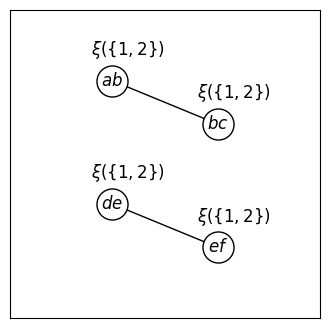

In [4]:
# Draw L(G1) and L(G2)

# Create line graph
# Create graph
LG = nx.Graph()
n1 = 'uv'
n2 = 'vw'
n3 = 'xy'
n4 = 'yz'
node_ids = [n1, n2, n3, n4]

LG.add_nodes_from([
    (n1, dict(name="$ab$", label1="$\\xi (\{ 1,2 \})$")),
    (n2, dict(name="$bc$", label1="$\\xi (\{ 1,2 \})$")),
    (n3, dict(name="$de$", label1="$\\xi (\{ 1,2 \})$")),
    (n4, dict(name="$ef$", label1="$\\xi (\{ 1,2 \})$")),
])
LG.add_edge(n1, n2)
LG.add_edge(n3, n4)

# Set node positions
positions = np.array([
    (original_graph_positions[0] + original_graph_positions[1]) / 2,
    (original_graph_positions[1] + original_graph_positions[2]) / 2,
    (original_graph_positions[3] + original_graph_positions[4]) / 2,
    (original_graph_positions[4] + original_graph_positions[5]) / 2,
])
positions -= (positions.max(axis=0) + positions.min(axis=0))/2  # center the positions
node_pos = position_dict(node_ids, positions)

# Set label positions
label_positions = positions + np.array([0.1, 0.2])
label_pos = position_dict(node_ids, label_positions)

# Labels to display
node_names = {node: data['name'] for node, data in LG.nodes(data=True)}
node_labels1 = {node: data['label1'] for node, data in LG.nodes(data=True)}

# Draw G1
plt.figure(frameon=False, figsize=(4, 4))
plt.xlim(-1,1)
plt.ylim(-1,1)
nx.draw_networkx_nodes(LG, node_pos, node_size=500, node_color='white', edgecolors='black')
nx.draw_networkx_labels(LG, labels=node_names, pos=node_pos)
nx.draw_networkx_labels(LG, labels=node_labels1, pos=label_pos)
nx.draw_networkx_edges(LG, node_pos, edgelist=LG.edges())
plt.show()